# Building a Recommender System from Scratch

### Step 1: Import Dependencies

We are using [pandas.DataFrame](http://pandas.pydata.org/pandas-docs/version/0.19/generated/pandas.DataFrame.html) to represent our data. We will visualize our data with [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/).

**What is a DataFrame?**

- a two-dimensional Pandas data structure
- columns represent features, rows represent items
- analogous to an Excel spreadsheet or SQL table
- documentation can be found here

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NB: if you get any deprecation errors when running the code below, update packages as below
# !pip install numpy --upgrade

### Step 2: Load Data

Let's download a small version of the MovieLens dataset. You can download the data [here](https://grouplens.org/datasets/movielens/). We're working with data in `ml-latest-small.zip` and will need to add the following files to our repository:

- ratings.csv
- movies.csv

Alternatively, you can access the data here:

- https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv
- https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv

In [2]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')

In [3]:
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

### Step 3: Exploratory Data Analysis

In [4]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


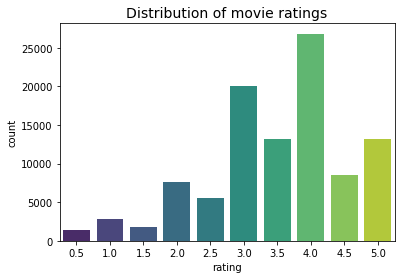

In [5]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [6]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.5.
Mean rating per user: 3.66.


#### Best vs. Worst Movie

Which movie has the lowest and highest average rating?

In [7]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId'] == lowest_rated]


,movieId,title,genres
2689,3604,Gypsy (1962),Musical


`Gypsy` has the lowest average rating.

In [8]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


Lamerica may be the "highest" rated movie, but it only has one rating. A better approach for evaluating movie popularity is to do look at the [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average).

#### Bayesian Average

Bayesian Average is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. In this case, our prior will be the average rating across all movies. By defintion, C represents "the typical data set size". Let's make $C$ be the average number of ratings for a given movie.

In [9]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

# we need to fix an index problem real quick that was present in the notebook presented at the conference
print(movie_stats.head())
# as we can see, 'movieId' is presently an index, and not a column
# to make it callable, we need to fix that and ensure the change works

# use the method below as opposed to just creating a new column to avoid the ambiguity warning
movie_stats.reset_index(level=0, inplace=True)
print(movie_stats.head())
# now we're good to proceed!

         count      mean
movieId                 
1          215  3.920930
2          110  3.431818
3           52  3.259615
4            7  2.357143
5           49  3.071429
   movieId  count      mean
0        1    215  3.920930
1        2    110  3.431818
2        3     52  3.259615
3        4      7  2.357143
4        5     49  3.071429


In [10]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [11]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392070,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236457,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227052,Fight Club (1999)
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.190567,"Usual Suspects, The (1995)"


Using the Bayesian average, we see that `Shawshank Redemption`, `The Godfather`, and `The Usual Suspects` are the most highly rated movies. This result makes much more sense since these movies are critically acclaimed films.

In [12]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190377,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224426,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267268,Godzilla (1998)
1144,1499,27,1.925926,2.296800,Anaconda (1997)
1988,2643,16,1.687500,2.306841,Superman IV: The Quest for Peace (1987)


With Bayesian averaging, it looks like `Speed 2: Cruise Control`, `Battlefield Earth`, and `Godzilla` are the worst rated movies. `Gypsy` isn't so bad after all.

#### A Glimpse at Movie Genres

The movies dataset needs to be cleaned in two ways:

- `genres` is expressed as a string with a pipe `|` separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
- `title` currently has (year) appended at the end. We will extract year from each title string and create a new column for it.

In [13]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


**How many movie genres are there?**

In [14]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [15]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


### Step 4: Data Pre-processing

We are going to use a technique called colaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things. 

The first step is to transform our data into a user-item matrix, also known as a "utility" matrix. In this matrix, rows represent users and columns represent movies. The beauty of collaborative filtering is that it doesn't require any information about the users or the movies user to generate recommendations.

<img src="imgs/user-movie-matrix.png" width=60%/>

The `create_X()` function outputs a sparse matrix X with four mapper dictionaries:

- **user_mapper**: maps user id to user index
- **movie_mapper**: maps movie id to movie index
- **user_inv_mapper**: maps user index to user id
- **movie_inv_mapper**: maps movie index to movie id

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.

Our X (user-item) matrix is a [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) which stores the data sparsely.

In [16]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

#### Evaluating sparsity

Here, we calculate sparsity by dividing the number of stored elements by total number of elements. The number of stored (non-empty) elements in our matrix is equivalent to the number of ratings in our dataset.

In [17]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


`csr_matrix.nnz` counts the stored values in our sparse matrix. The rest of our cells are empty.

The **cold start problem** is when there are new users and movies in our matrix that do not have any ratings. In our Movielens dataset, all users and movies have at least one rating but in general, it's useful to check which users and movies have few interactions.

In [18]:
n_ratings_per_user = X.getnnz(axis=1)

print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [19]:
n_ratings_per_movie = X.getnnz(axis=0)

print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


/Users/pauljeffries/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


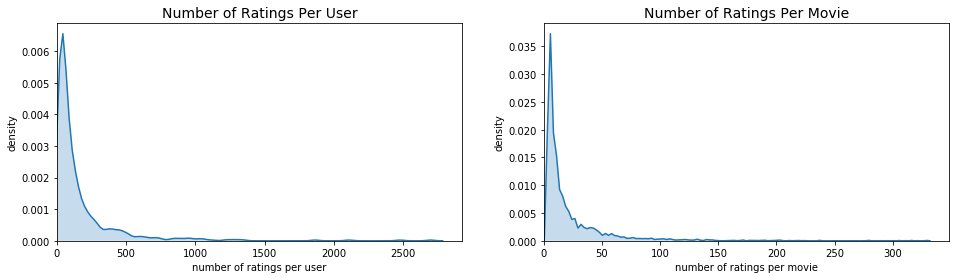

In [20]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

#### Normalizing our data

User-item bias is defined as: $b_{ui} = \mu + b_{u} + b_{i}$

We will perform mean normalization by subtracting $b_{i}$ from each movie's rating.

In [21]:
sum_ratings_per_movie = X.sum(axis=0)
mean_rating_per_movie = sum_ratings_per_movie/n_ratings_per_movie

Now that we have the mean rating for each movie, we are going to subtract this from our utility matrix. In order to do this, we need to expand our 1D `mean_rating_per_movie` array into a matrix with the same shape as our utility matrix `(n_users, n_movies)`. Numpy's `tile` method is useful for this task.

In [22]:
X_mean_movie = np.tile(mean_rating_per_movie, (X.shape[0],1))

In [23]:
X_mean_movie.shape

(610, 9724)

`X_mean_movie` is a matrix of shape (n_users, n_movies) in which each column is populated with a given movie's mean rating.

We can easily normalize our X matrix by subtracting `X_mean_movie` from original `X`.

In [24]:
X_norm = X - csr_matrix(X_mean_movie)

As expected, `X_norm`'s values are different from `X`s. Cells that are empty in the original matrix are now replaced with negative values representing the mean rating of a given movie. 

In [25]:
print("Original X:", X[0].todense())
print("Normalized X:", X_norm[0].todense())

Original X: [[4. 0. 4. ... 0. 0. 0.]]
Normalized X: [[ 0.07906977 -3.43181818  0.74038462 ... -3.5        -3.5
  -4.        ]]


### Step 5: Item-item Recommendations with k-Nearest Neighbors

We are going to find the $k$ movies that have the most similar user engagement vectors for movie $i$.

In [26]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

`find_similar_movies()` takes in a `movieId` and `X` matrix, and outputs a list of $k$ movies that are similar to the `movieId` of interest.

Let's see how it works in action. We will first create another mapper that maps movieId to title so that our results are interpretable.

In [27]:
similar_movies = find_similar_movies(1, X_norm, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[3114, 78499, 2054, 788, 2355, 2018, 596, 2078, 673]

`find_similar_movies()` returns a list of `movieId`'s that are most similar to your movie of interest. Let's convert these id's to titles so that we can interpret our results. To make things easier, we will create a dictionary that maps `movieId` to `title`.

In [28]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X_norm, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Toy Story 3 (2010)
Honey, I Shrunk the Kids (1989)
Nutty Professor, The (1996)
Bug's Life, A (1998)
Bambi (1942)
Pinocchio (1940)
Jungle Book, The (1967)
Space Jam (1996)


The results above show the 10 movies that are most similar to Toy Story. Most movies in this list are family movies from the 1990s, which seems pretty reasonable. Note that these recommendations are based solely on user-item ratings. Movie features such as genres are not used in this approach.

You can also play around with the kNN distance metric and see what results you would get if you use "manhattan" or "euclidean" instead of "cosine".

In [29]:
movie_id = 1

similar_movies = find_similar_movies(movie_id, X_norm, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Honey, I Shrunk the Kids (1989)
Nutty Professor, The (1996)
Space Jam (1996)
Mighty Ducks, The (1992)
The Amazing Spider-Man 2 (2014)
Popeye (1980)
Hocus Pocus (1993)
Lost World: Jurassic Park, The (1997)
Snakes on a Plane (2006)


### Step 6: Handling the cold-start problem

Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no iteractions get excluded from the recommendation system. This is called the **cold start problem**. Content-based filtering is a way to handle this problem by generating recommendations based on user and item features.

First, we need to convert the `genres` column into binary features. Each genre will have its own column in the dataframe, and will be populated with 0 or 1.

In [30]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


In [31]:
!pip install pandas --upgrade

Requirement already up-to-date: pandas in /Users/pauljeffries/anaconda3/lib/python3.6/site-packages (0.23.4)


In [32]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))
    
movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


The dimensions of our cosine similarity matrix are $M \times M$ where $M$ represents the total number of movies.

In [34]:
def movie_finder(title):
    return movies[movies['title'].str.contains(title)]['title'].tolist()

movie_finder('Toy Story')

['Toy Story (1995)', 'Toy Story 2 (1999)', 'Toy Story 3 (2010)']

In [35]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
title = movie_finder('Toy Story')[0]
n_recommendations = 10

idx = movie_idx[title]
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

print(f"Recommendations for {title}:")
movies['title'].iloc[similar_movies]

Recommendations for Toy Story (1995):


1706                                          Antz (1998)
2355                                   Toy Story 2 (1999)
2809       Adventures of Rocky and Bullwinkle, The (2000)
3000                     Emperor's New Groove, The (2000)
3568                                Monsters, Inc. (2001)
6194                                     Wild, The (2006)
6486                               Shrek the Third (2007)
6948                       Tale of Despereaux, The (2008)
7760    Asterix and the Vikings (Astérix et les Viking...
8219                                         Turbo (2013)
Name: title, dtype: object

With this approach, we are assuming that two movies are "similar" if they have similar genres. These "similar movie" recommendations are based solely on the metadata from our movies dataset. Feel free to test out different movies.

### Step 7: Dimensionality Reduction with Matrix Factorization (advanced)

Matrix factorization (MF) is a linear algebra technique that can help us discover latent features underlying the interactions between users and movies. These latent features give a more compact representation of user tastes and item descriptions. MF is particularly useful for very sparse data and can enhance the quality of recommendations. The algorithm works by factorizing the original user-item matrix into two factor matrices:

- user-factor matrix (n_users, k)
- item-factor matrix (k, n_items)

We are reducing the dimensions of our original matrix into "taste" dimensions. We cannot interpret what each latent feature $k$ represents. However, we could imagine that one latent feature may represent users who like romantic comedies from the 1990s, while another latent feature may represent movies which are independent foreign language films.

$$X_{mn}\approx P_{mk}\times Q_{nk}^T = \hat{X} $$
<img src="imgs/matrix-factorization.png" width="50%"/>

In [36]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=10)
Z = svd.fit_transform(X.T)

In [37]:
movie_id = 1
similar_movies = find_similar_movies(movie_id, Z.T, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Home Alone (1990)
Jurassic Park (1993)
Aladdin (1992)
Back to the Future (1985)
Willy Wonka & the Chocolate Factory (1971)
Forrest Gump (1994)
Groundhog Day (1993)
Star Wars: Episode IV - A New Hope (1977)
Princess Bride, The (1987)


The results above are the most similar movies to Toy Story using kNN on our “compressed” movie-factor matrix. We reduced the dimensions down to n_components=30. We can think of each component representing a latent feature such as movie genre.

#### Predicting missing ratings to generate top N recommendations

With matrix factorization, we can also predict missing ratings in our original user-item matrix. We can do this by reconstructing our matrix by getting the inner product of our user-factor matrix and movie-factor matrix. We can use the `inverse_transform` on our movie-factor matrix Z to get our reconstructed user-item matrix.

In [38]:
new_X = svd.inverse_transform(Z).T

Let’s look at `userId=100`’s recommendations. In the table below, we can see which movies that have been rated highly:

In [39]:
userId = 100
user_preferences = ratings[(ratings['userId']==userId)&(ratings['rating']>=4)]
user_preferences = user_preferences.merge(movies[['movieId', 'title']])
user_preferences.sort_values('rating', ascending=False).head(10)

,userId,movieId,rating,timestamp,title
97,100,5620,5.0,1100186982,Sweet Home Alabama (2002)
89,100,4041,5.0,1100184235,"Officer and a Gentleman, An (1982)"
64,100,1958,5.0,1100186258,Terms of Endearment (1983)
45,100,1101,5.0,1100184137,Top Gun (1986)
75,100,2423,5.0,1100186118,Christmas Vacation (National Lampoon's Christm...
1,100,16,4.5,1100185959,Casino (1995)
36,100,919,4.5,1100183748,"Wizard of Oz, The (1939)"
82,100,3259,4.5,1100186037,Far and Away (1992)
40,100,934,4.5,1100186407,Father of the Bride (1950)
41,100,1028,4.5,1100185898,Mary Poppins (1964)


Now, let’s take a look at which movies we predict `userId=100` will like based on their previous ratings. We will need get the row which represents `userId=100` and sort their predicted ratings in descending order. `np.argsort()` is a useful method for getting the top N indices (i.e., movies with highest rating predictions) for `userId=100`.

In [40]:
top_N = 10

movie_titles = dict(zip(movies['movieId'], movies['title']))

top_N_indices = new_X[user_mapper[userId]].argsort()[-top_N:][::-1]

print(f"Top {top_N} Recommendations for UserId {userId}:")
for i in top_N_indices:
    movie_id = movie_inv_mapper[i]
    print(movie_titles[movie_id])

Top 10 Recommendations for UserId 100:
Forrest Gump (1994)
Pretty Woman (1990)
When Harry Met Sally... (1989)
Apollo 13 (1995)
Toy Story (1995)
Shakespeare in Love (1998)
Aladdin (1992)
Clueless (1995)
Four Weddings and a Funeral (1994)
Princess Bride, The (1987)


### Step 8: Evaluation

How do we know if our recommendations are good? The best way to evaluate our system is to test it in the wild with A/B testing or usability tests, where we can get direct feedback from users. However, this option is not always available which means that we need to use offline metrics. 

In traditional machine learning, we evaluate a model by splitting our data into two sets: 1) `training set` and 2) `validation set`. We train our model using the `training set`, then test our model on the `validation set`. In recommender systems, we can't split our data the traditional way because our model won't work if our training set represents a completely different user population than the validation set. Instead, we generate our `training set` by masking random interactions in our user-item matrix. In other words, we pretend that we don't if a user liked or hated Movie X, but we actually do. Once we train our model and generate our rating predictions, we can then compare our predicted rating with the actual rating. 

<img src="imgs/splitting.png" width="60%"/>

There are various ways to compare our predicted vs. actual ratings. The most common metrics include:
    
1) Root Mean Squared Error: $\text{RMSE} = \sqrt{\frac{\Sigma^N_{i=1}(y-\hat{y})^2}{N}}$

2) Precision: $\text{Precision} = \frac{TP}{TP+FP}$

3) Recall: $\text{Recall} = \frac{TP}{TP+FN}$